In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

In [3]:
original_data = pd.read_csv('../dataset/mohler2_cleaned.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'question_number':'question_id','question_text':'question','answer_model':'ref_answer','answer_student':'student_answer','score_avg':'grade'})

In [4]:
df = original_data.copy()

#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

df

,question_id,question,ref_answer,student_answer,grade,ref_modified,student_modified
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,simulate behaviour portion desired software pr...,high risk problem address prototype program ma...
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,simulate behaviour portion desired software pr...,simulate portion desired final product quick e...
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,simulate behaviour portion desired software pr...,prototype program simulates behavior portion d...
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,simulate behaviour portion desired software pr...,defined specification phase prototype stimulat...
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,simulate behaviour portion desired software pr...,used let user first idea completed program all...
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,simulate behaviour portion desired software pr...,find problem error program finalized
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,simulate behaviour portion desired software pr...,address major issue creation program way accou...
7,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,you can break the whole program into prototype...,5.0,simulate behaviour portion desired software pr...,break whole program prototype program simulate...
8,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To provide an example or model of how the fini...,3.5,simulate behaviour portion desired software pr...,provide example model finished program perfom ...
9,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Simulating the behavior of only a portion of t...,5.0,simulate behaviour portion desired software pr...,simulating behavior portion desired software p...


In [5]:
short_df = df[['student_answer','student_modified', 'grade','question']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)

/home/black-book/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/black-book/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
short_df

,student_answer,student_modified,grade,question,status
0,High risk problems are address in the prototyp...,high risk problem address prototype program ma...,3.5,What is the role of a prototype program in pro...,1
1,To simulate portions of the desired final prod...,simulate portion desired final product quick e...,5.0,What is the role of a prototype program in pro...,1
2,A prototype program simulates the behaviors of...,prototype program simulates behavior portion d...,4.0,What is the role of a prototype program in pro...,1
3,Defined in the Specification phase a prototype...,defined specification phase prototype stimulat...,5.0,What is the role of a prototype program in pro...,1
4,It is used to let the users have a first idea ...,used let user first idea completed program all...,3.0,What is the role of a prototype program in pro...,1
5,To find problem and errors in a program before...,find problem error program finalized,2.0,What is the role of a prototype program in pro...,0
6,To address major issues in the creation of the...,address major issue creation program way accou...,2.5,What is the role of a prototype program in pro...,0
7,you can break the whole program into prototype...,break whole program prototype program simulate...,5.0,What is the role of a prototype program in pro...,1
8,To provide an example or model of how the fini...,provide example model finished program perfom ...,3.5,What is the role of a prototype program in pro...,1
9,Simulating the behavior of only a portion of t...,simulating behavior portion desired software p...,5.0,What is the role of a prototype program in pro...,1


In [7]:
# short_df['word_count'] = short_df['student_answer'].apply(lambda x: dict(Counter(x.split())))

# counting unique words in every student's answer
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = short_df['status'].values

In [8]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = [0, 5, 6 ,100]
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
lr = LogisticRegression()
learner = ActiveLearner(
    estimator = lr,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = 40
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
    print("\nQ: ", act_data.loc[int(query_idx),'question'])
    print("A: ",act_data.loc[int(query_idx),'student_answer'])
    print("Actual grade: ",y_pool[query_idx].reshape(1, ))
    print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
    human_label = int(input("\nGive me a grade 0 or 1:"))
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=[human_label]
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X,Y))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X, Y)))


Q:  What are the main advantages associated with object-oriented programming?
A:  The main advantages to object-oriented programming are that existing classes can be reused and program maintenance and verification are easier. 
Actual grade:  [1]
Class probabilities:  [[0.49856209 0.50143791]]

Give me a grade 0 or 1:1
Accuracy after query no. 1: 0.828829

Q:  What is the role of a prototype program in problem solving?
A:  To lay out the basics and give you a starting point in the actual problem solving. 
Actual grade:  [0]
Class probabilities:  [[0.50054706 0.49945294]]

Give me a grade 0 or 1:0
Accuracy after query no. 2: 0.773137

Q:  What is a pointer?
A:  pointer is a programming data type whose value points to another value stored in computer memory by its address. 
Actual grade:  [1]
Class probabilities:  [[0.49991169 0.50008831]]

Give me a grade 0 or 1:1
Accuracy after query no. 3: 0.821048

Q:  How are arrays passed to functions?
A:  the same way but with [] at the declaratio


Give me a grade 0 or 1:1
Accuracy after query no. 23: 0.872645

Q:  What is the experimental approach for measuring the running time of an algorithm?
A:  Using some sort of counting principle of the number of operations performed in an algorithm. 
Actual grade:  [1]
Class probabilities:  [[0.45932723 0.54067277]]

Give me a grade 0 or 1:1
Accuracy after query no. 24: 0.872236

Q:  Which implementation (array-based vs. list-based) is preferred for a queue  and why?
A:  list based becuase an arrary based has to have an arrary size and needs to be pre-defined and cannot be changed dynamically. 
Actual grade:  [1]
Class probabilities:  [[0.39230137 0.60769863]]

Give me a grade 0 or 1:1
Accuracy after query no. 25: 0.872236

Q:  When defining a recursive function  what are possible causes for infinite recursion?
A:  improper handling of cases such that not all possible values are able to be handled. 
Actual grade:  [1]
Class probabilities:  [[0.37381634 0.62618366]]

Give me a grade 0 or 

## Regular supervised task

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)

In [11]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)
score = logisticRegr.score(X_test, Y_test)

print(score)

0.8773006134969326


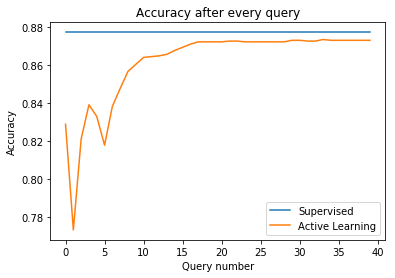

In [12]:
supervised_accuracy = [score for x in range(0,40)]

plt.figure()
plt.plot(np.linspace(0,39,40),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()